# Behavioral Cloninig Project

---

## Training a model with Keras and Generator

# Import Libraries

In [105]:
import os
import csv
import cv2
import time
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import StrMethodFormatter
# Visualizations will be shown in the notebook.
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D

# Dataset Pre Processing

Dataset Summary:
Total Training samples = 24926
Total Validation samples = 6232


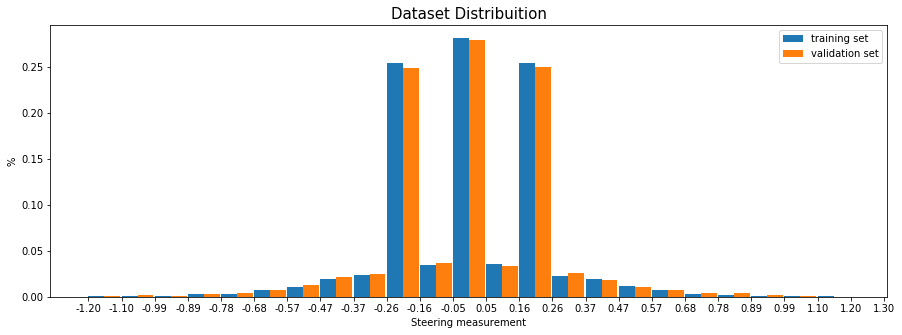

In [122]:
# Training params
validation_split = 0.2

# Create an sample array from driving_log.csv
# Each line will correspond to an [image_path, measurement,augmented_flag]
samples = []

# Select which recorded trainings will be used
samples_folders=["data2","data_recovery"]

# Steering correction definition
steering_correction = 0.2
steering_correction_arr = [0.0, steering_correction, -1.0*steering_correction]

# Load the samples array with a pair of a single image and the steering angle corrected
for sf in samples_folders:
    with open("./{}/driving_log.csv".format(sf)) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            for i in range(len(steering_correction_arr)):
                # Add both normal and augmented entry, to be processed in the generator
                # This approach would benefit shuffling the dataset
                samples.append([line[i],float(line[3]) + steering_correction_arr[i],False])
                samples.append([line[i],float(line[3]) + steering_correction_arr[i],True])



# Define generator function to load images and augmented image/measurement when needed
def generator(samples, batch_size=32):
    num_samples = len(samples)

    while 1: # Loop forever so the generator never terminates
        shuffle(samples)

        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurements = []

            # Iterate over each sample in batch_samples
            for batch_sample in batch_samples:
                # Load image
                image = mpimg.imread(batch_sample[0])
                measurement = batch_sample[1]

                # Check if augmented flag is set
                if(batch_sample[2]):
                    # Append a new augmented version of each sample by fliping it image in horizontal and inverting measurement sign
                    # This will duplicate the training dataset
                    images.append(cv2.flip(image,1))
                    measurements.append(-1.0*measurement)

                else:
                    # Append sample image and the respective pre corrected steering angle measurement
                    images.append(image)
                    measurements.append(measurement)

            # build the batched training dataset
            X_train = np.array(images)
            y_train = np.array(measurements)

            # return the batch dataset
            yield sklearn.utils.shuffle(X_train, y_train)

# Create train and validation samples filenames arrays
train_samples, validation_samples = train_test_split(shuffle(samples), test_size=validation_split)

# helper function to calculate dataset histogram
def summarize_dataset(dataset, name="dataset",bins=10):
    m_arr = np.array([-1.0*row[1] if row[2] else row[1] for row in dataset])
    m_histogram = np.histogram(m_arr,bins=bins,range=(-1.0-steering_correction,1.0+steering_correction))
    print("Total {} samples = {}".format(name,len(m_arr)))
    return m_histogram

# Print a dataset summary
print("Dataset Summary:")
bins=23
train_hist = summarize_dataset(train_samples, "Training",bins=bins)
valid_hist = summarize_dataset(validation_samples, "Validation",bins=bins)

### plot the training and validation distribuition
bar_w = 0.05
plt.figure(figsize=(15,5))
plt.bar(train_hist[1][:bins],train_hist[0]/sum(train_hist[0]),width=bar_w,align="edge")
plt.bar(valid_hist[1][:bins]+bar_w,valid_hist[0]/sum(valid_hist[0]),width=bar_w,align="edge")
plt.title("Dataset Distribuition", fontsize=15)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.xticks(np.arange(-1.2, 1.4, step=2.4/bins))
plt.ylabel("%")
plt.xlabel("Steering measurement")
plt.legend(['training set', 'validation set'], loc='upper right')
# plt.savefig("dataset_distribution.png")
plt.show()

# Training Pipeline

In [137]:
# Initialize Keras sequential model
model = Sequential()

# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: x/ 255.0 -0.5,input_shape=(160,320,3)))
# Crop image on the relevant area of the road
model.add(Cropping2D(cropping=((70,25),(0,0))))

# Build model published by the autonomous vehicle team at NVIDIA
model.add(Convolution2D(24,(5,5),strides=(2,2),activation="relu"))
model.add(Convolution2D(36,(5,5),strides=(2,2),activation="relu"))
model.add(Convolution2D(48,(5,5),strides=(2,2),activation="relu"))
model.add(Convolution2D(64,(3,3),activation="relu"))
model.add(Convolution2D(64,(3,3),activation="relu"))
model.add(Flatten())
model.add(Dense(100,activation="relu"))
model.add(Dense(50,activation="relu"))
# model.add(Dropout(0.2))
model.add(Dense(10,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1))

# Show model layers summary
print("\nModel Summary:")
model.summary()

# Training params
epoch = 4
batch_size = 128

# Compile and train the model using the generator function.
# NOTE: passing batch_size because generator will internally append 6 images per sample
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

print("\nTraining params:")
print("Epochs\t\t\t\t= {}".format(epoch))
print("Batch size\t\t\t= {}".format(batch_size))
print("Total training samples  \t= {}\t| steps per batch = {}".format(len(train_samples), ceil(len(train_samples)/batch_size)))
print("Total validation samples\t= {}\t| steps per batch = {}".format(len(validation_samples), ceil(len(validation_samples)/batch_size)))
print("\nStart training with generator:\n")

# Train model with mean square error loss and adam optimizer
ts = time.time()
model.compile(loss='mse', optimizer='adam')
generator_history_object = model.fit_generator(train_generator, 
                                steps_per_epoch=ceil(len(train_samples)/batch_size),
                                validation_data=validation_generator,
                                validation_steps=ceil(len(validation_samples)/batch_size),
                                epochs=epoch, 
                                verbose=2)
                                
# Save model
model.save('{}_model.h5'.format(int(ts)))
print("Model saved! Filename: {}_model.h5".format(epoch,int(ts)))


Model Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_8 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_8 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 31, 158, 24)       1824      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 14, 77, 36)        21636     
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 5, 37, 48)         43248     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 3, 35, 64)         27712     
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 1, 33, 64)         36928

# Plot Training Results

[0.030164006684989652, 0.02565794927017614, 0.02465647689831957, 0.024509007502761217]


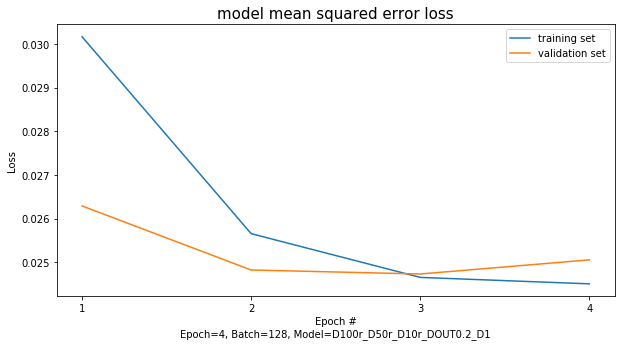

In [139]:
### plot the training and validation loss for each epoch
print(generator_history_object.history['loss'])
plt.figure(figsize=(10,5))
x_axis = np.arange(1, len(generator_history_object.history['loss'])+1, step=1)
plt.plot(x_axis,generator_history_object.history['loss'])
plt.plot(x_axis,generator_history_object.history['val_loss'])

plt.title('model mean squared error loss', fontsize=15)
plt.ylabel('Loss')
plt.xlabel('Epoch #\nEpoch={}, Batch={}, Model={}'.format(epoch,batch_size,"D100r_D50r_D10r_DOUT0.2_D1"))
# plt.xticks(np.arange(len(generator_history_object.history['loss'])))
plt.xticks(x_axis)
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig("images/{}_training_mse.png".format(epoch,int(ts)))
plt.show()

# Model Visualization

In [141]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='images/{}_model.png'.format(int(ts)), show_shapes=True, show_layer_names=True)